# **Advanced DNN with Callbacks and Adaptive Learning Rate**

*Objective: Develop an advanced DNN with sophisticated features such as callbacks and adaptive learning rates for enhanced performance and stability*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

2024-10-01 13:00:53.324909: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 13:00:54.008502: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {x_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3), Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3), Testing labels shape: (10000, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Training data mean: 0.0000, std: 1.0000
y_train shape: (50000, 10)
y_test shape: (10000, 10)
one-hot coded label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


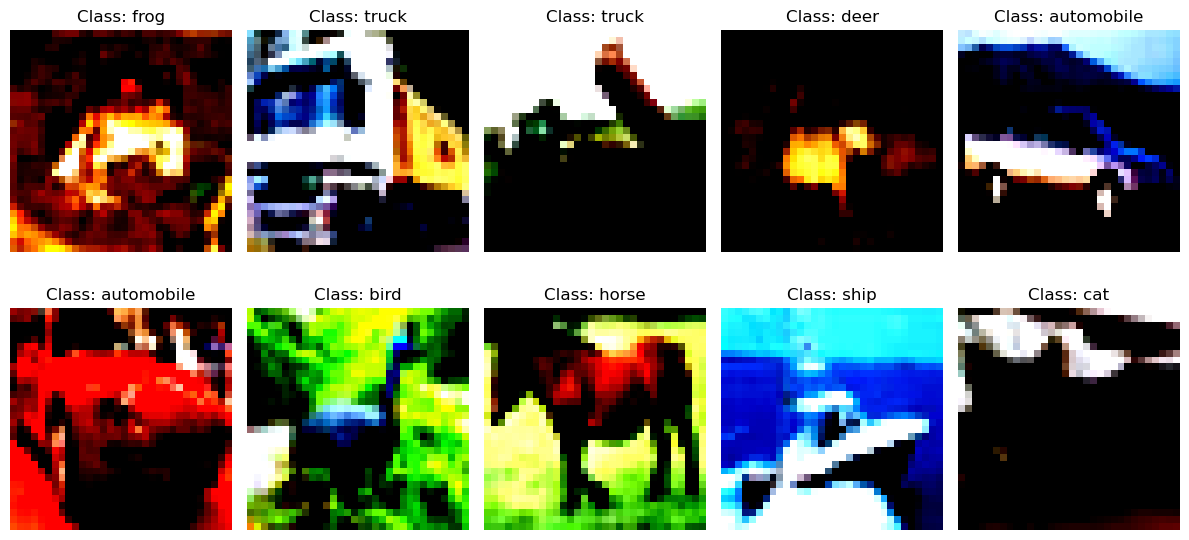

In [3]:
# Z-score normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

mean = np.mean(x_train, axis=(0, 1, 2, 3))
std = np.std(x_train, axis=(0, 1, 2, 3))
x_train = (x_train - mean) / (std + 1e-7)
x_test = (x_test - mean) / (std + 1e-7)
print(f"Training data mean: {np.mean(x_train):.4f}, std: {np.std(x_train):.4f}")

# One-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"one-hot coded label: {y_train[0]}")
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    class_label = class_names[np.argmax(y_train[i])]
    plt.title(f"Class: {class_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
#architecture
model = models.Sequential([
    #input layer
    layers.Input(shape=(32, 32, 3)),

    #first hidden
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    #second hidden
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    #third hidden
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    #flatten
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       2

2024-10-01 13:00:57.580703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8889 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:42:00.0, compute capability: 7.5


In [5]:
# callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

class ValidationPrecision(callbacks.Callback):
    def __init__(self, validation_data):
        super(ValidationPrecision, self).__init__()
        self.validation_data = validation_data
        self.precision = tf.keras.metrics.Precision()

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y = self.validation_data
        val_predictions = np.argmax(self.model.predict(val_x), axis=1) # get model predictions
        val_labels = np.argmax(val_y, axis=1)
        self.precision.update_state(val_labels, val_predictions) #update precision
        precision_result = self.precision.result().numpy() #precision result
        print(f' — val_precision: {precision_result:.4f}')
        self.precision.reset_state() # reset

validation_precision = ValidationPrecision(validation_data=(x_test, y_test))

from tensorflow.keras import backend as K

class LearningRateLogger(callbacks.Callback):
    def __init__(self):
        super(LearningRateLogger, self).__init__()
        self.lrs = []  # learning rates

    def on_epoch_end(self, epoch, logs=None):
        lr = K.eval(self.model.optimizer.learning_rate)
        self.lrs.append(lr)
        print(f" — Learning Rate: {lr:.6f}")

learning_rate_log = LearningRateLogger()
callback_list = [early_stop, model_checkpoint, reduce_lr, validation_precision, learning_rate_log]

initial_lr = 1e-3
optimizer = optimizers.Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## **Training and Evaluation**

In [6]:
with tf.device('/GPU:0'):
    history = model.fit(
        x_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(x_test, y_test),
        callbacks=callback_list,
        verbose=1
    )


best_model = models.load_model('best_model.keras')
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

Epoch 1/50


2024-10-01 13:01:00.079870: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-10-01 13:01:00.269087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-10-01 13:01:00.522494: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f55c8ce4ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-01 13:01:00.522531: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-10-01 13:01:00.527003: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-01 13:01:00.667855: I ./tensorflow/compiler/jit/device_compiler.h:180] C

313/313 [==============================] - 1s 2ms/step loss: 1.55
 — val_precision: 0.9503
 — Learning Rate: 0.001000
1563/1563 [==============================] - 17s 9ms/step - loss: 1.5599 - accuracy: 0.4637 - val_loss: 1.1618 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 2/50
313/313 [==============================] - 1s 2ms/step loss: 1
 — val_precision: 0.9575
 — Learning Rate: 0.001000
1563/1563 [==============================] - 13s 8ms/step - loss: 1.1094 - accuracy: 0.6098 - val_loss: 0.8976 - val_accuracy: 0.6851 - lr: 0.0010
Epoch 3/50
313/313 [==============================] - 1s 2ms/step loss: 0
 — val_precision: 0.9672
 — Learning Rate: 0.001000
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9795 - accuracy: 0.6569 - val_loss: 0.7853 - val_accuracy: 0.7301 - lr: 0.0010
Epoch 4/50
313/313 [==============================] - 1s 2ms/step loss: 0
 — val_precision: 0.9730
 — Learning Rate: 0.001000
1563/1563 [==============================] - 13s 8ms/step - los

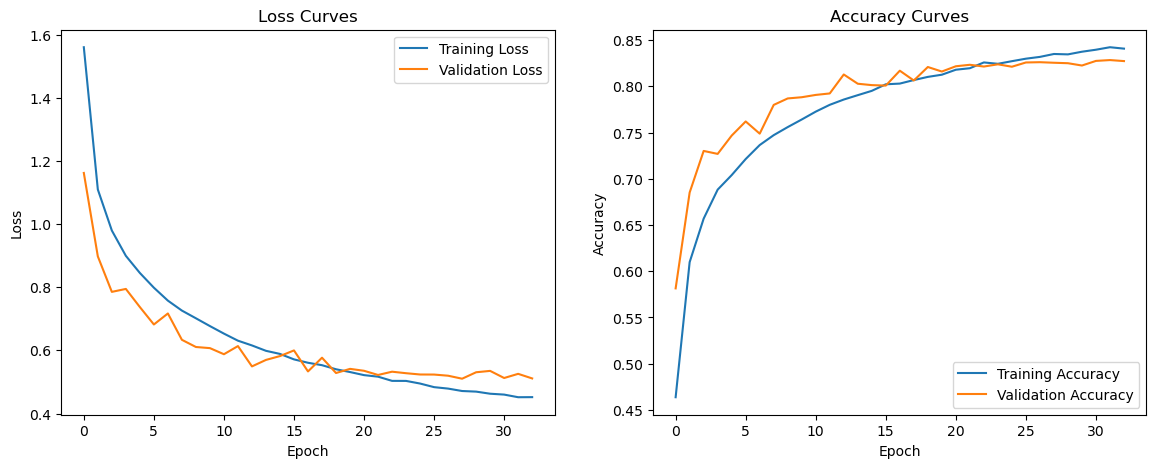

In [8]:
# training and validation loss
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# training and validation accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
